In [1]:
import sys
import os
sys.path.append("..") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.preprocessing import Preprocessor
from src.lstm_forecasting import LSTMForecaster
from sklearn.metrics import mean_squared_error

# Pour ne pas afficher de warnings inutiles
import warnings
warnings.filterwarnings("ignore")

In [2]:
champs_elysees_df = pd.read_csv('../data/traffic/champs_elysees.csv', sep=";")
# convention_df = pd.read_csv('../data/traffic/convention.csv', sep=";")
# sts_peres_df = pd.read_csv('../data/traffic/sts_peres.csv', sep=";")

weather_df = pd.read_csv('../data/weather/weather_paris.csv')
holidays_df = pd.read_csv('../data/events/french_holidays.csv', sep=";")
football_matches_df = pd.read_csv('../data/events/football_matches_2024_2025.csv')

In [3]:
preprocessor = Preprocessor(df=champs_elysees_df)

# On applique ton pipeline de preprocessing
df_processed = preprocessor.fit_transform(holidays_df=holidays_df, weather_df=weather_df, sports_df=football_matches_df)

print("Preprocessed Data :", df_processed.shape)
display(df_processed.sample(5))


Preprocessed Data : (8627, 43)


,Identifiant arc,Libelle,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,...,relative_humidity_2m (%),precipitation (mm),wind_speed_10m (km/h),weather_code (wmo code),surface_pressure (hPa),cloud_cover (%),apparent_temperature (°C),rain (mm),sport_event_name,is_sport_event
Date et heure de comptage,,,,,,,,,,,,,,,,,,,,,
2025-08-15 09:00:00,4264,AV_Champs_Elysees,354.000000,4.886670,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-06-30 20:00:00,4264,AV_Champs_Elysees,989.833333,20.290275,Inconnu,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2024-12-31 06:00:00,4264,AV_Champs_Elysees,151.000000,1.872220,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-01-10 14:00:00,4264,AV_Champs_Elysees,848.000000,18.165000,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2025-06-06 05:00:00,4264,AV_Champs_Elysees,205.000000,2.229440,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Ouvert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [4]:
forecaster = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2
)

# Preparation of sequences
X_train, X_test, y_train, y_test = forecaster.prepare_data(df_processed)

# Training
history = forecaster.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0896 - val_loss: 0.0288
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0342 - val_loss: 0.0248
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0302 - val_loss: 0.0237
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0279 - val_loss: 0.0230
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0262 - val_loss: 0.0215


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Débit horaire : RMSE = 245.04, Mean = 767.85, Relative error = 31.91%
Taux d'occupation : RMSE = 7.89, Mean = 15.96, Relative error = 49.40%


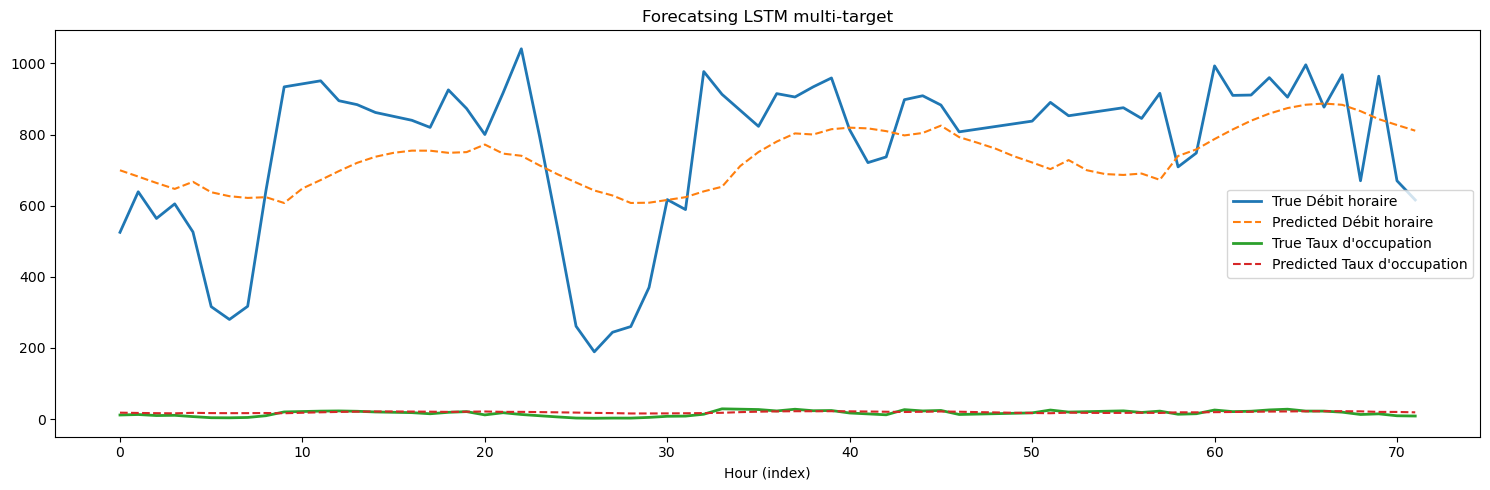

In [5]:
y_test_inv, y_pred_inv = forecaster.evaluate(X_test, y_test)

# Visualisation on the first 72 hours
forecaster.plot_predictions(y_test_inv, y_pred_inv, n_plot=72)

In [19]:
## Hybrid LSTM + XGBoost model
from src.xgb_forecasting import XGBoostModel

### LSTM for short-term patterns
lstm_model = LSTMForecaster(
    seq_length= 168,  # 7 historical days
    pred_length=72,  # prediction 72h in advance
    lstm_units=64,
    dropout=0.2
)

# Preparation of sequences
X_train, X_test, y_train, y_test = lstm_model.prepare_data(df_processed)

# Training
history = lstm_model.train(
    X_train, y_train,
    X_test, y_test,
    epochs=5, batch_size=32
)

# Predictions LSTM
y_test_inv, y_pred_inv = lstm_model.evaluate(X_test, y_test)

### XGBoost for long-term patterns
# Compute daily averages
daily_df = df_processed.groupby('date').agg({
    'Débit horaire':'mean',
    "Taux d'occupation":'mean',
    'is_holiday':'first',
    'is_sport_event':'first',
    'temperature_2m (°C)':'mean',
    'wind_speed_10m (km/h)':'mean',
    'precipitation (mm)':'mean',
    'cloud_cover (%)':'mean'
}).reset_index()

# Features for XGBoost
features_xgb = ['is_holiday','is_sport_event','temperature_2m (°C)',
                'wind_speed_10m (km/h)','precipitation (mm)','cloud_cover (%)']

# Instanciate XGBoost
xgb_model = XGBoostModel(daily_df, features_xgb, lstm_model.targets)
xgb_model.prepare_data(train_ratio=0.8)
xgb_model.fit()

# Predictions XGBoost (long-term)
y_pred_xgb = xgb_model.predict()

# ### Combine LSTM and XGBoost predictions
# # S'assurer que les dimensions sont compatibles
# # (il faudra éventuellement interpoler daily -> hourly pour aligner avec LSTM)
# y_pred_xgb_expanded = np.repeat(y_pred_xgb, 24, axis=0)[:len(y_pred_lstm)]

# # Fusion
# alpha = 0.7  # pondération LSTM court terme
# y_pred_final = alpha * y_pred_lstm + (1-alpha) * y_pred_xgb_expanded

# Combine LSTM and XGBoost predictions
# Step 1: Flatten LSTM predictions to hourly
y_test_inv, y_pred_lstm_array = lstm_model.evaluate(X_test, y_test)
n_samples, pred_length, n_targets = y_pred_lstm_array.shape
y_pred_lstm_hourly = y_pred_lstm_array.reshape(-1, n_targets)  # shape -> (n_samples*pred_length, n_targets)

# Step 2: Expand XGBoost daily predictions to hourly
# Répéter chaque prédiction 24 fois pour obtenir hourly
y_pred_xgb_hourly = np.repeat(y_pred_xgb, 24, axis=0)

# Step 3: Ajuster la longueur pour correspondre à LSTM
n_hours = y_pred_lstm_hourly.shape[0]
if y_pred_xgb_hourly.shape[0] < n_hours:
    # si pas assez de jours, on peut répéter le dernier jour
    last_row = y_pred_xgb_hourly[-1:]
    repeats = n_hours - y_pred_xgb_hourly.shape[0]
    y_pred_xgb_hourly = np.vstack([y_pred_xgb_hourly, np.repeat(last_row, repeats, axis=0)])
elif y_pred_xgb_hourly.shape[0] > n_hours:
    # tronquer si trop long
    y_pred_xgb_hourly = y_pred_xgb_hourly[:n_hours]

# Step 4: Fusion LSTM + XGBoost
alpha = 0.7
y_pred_final = alpha * y_pred_lstm_hourly + (1-alpha) * y_pred_xgb_hourly


Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.1000 - val_loss: 0.0315
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0341 - val_loss: 0.0244
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0300 - val_loss: 0.0238
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0279 - val_loss: 0.0229
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0261 - val_loss: 0.0216
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step
Débit horaire : RMSE = 246.03, Mean = 767.85, Relative error = 32.04%
Taux d'occupation : RMSE = 7.85, Mean = 15.96, Relative error = 49.15%
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Débit horaire : RMSE = 246.03, Mean = 767.85, Relative error = 32.04%
Taux d'occupation : RMSE = 7.85, Mean = 15.96, Relative error = 49.15%
